In [1]:
import os
import sys

sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname("../bpepi/bpepi"))))
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname("../bpepi"))))

import bpepi
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [2]:
import networkx as nx
import numpy as np

In [131]:
def simulate_one_detSIR(G, p_inf = 0.01, mask = ["SI"]):
    N=G.number_of_nodes()
    # Generate the sources
    status_nodes = []
    s0 = []
    flag_s=0
    p_inf=delta
    mask=[1]*Delta
    flag_m = 1
    if mask == ["SI"] : 
        mask = [1]
        flag_m = 0
    counter = [mask.copy() for _ in range(N)]
    coeff_lam = np.ones(N)
    for i in range(N):
        if np.random.rand() < p_inf : 
            s0.append(1)
            coeff_lam[i]=counter[i][0]
            if flag_m : counter[i].pop(0)
            flag_s =1
        else : s0.append(0)

    if (flag_s==0) : 
        s0[np.random.randint(0,N)]=1
        print("No sources... adding a single random source")
    status_nodes.append(np.array(s0))
    # Generate the epidemics
    st = np.copy(s0)
    while ((flag_m==1 and 1 in status_nodes[-1]) or (flag_m==0 and 0 in status_nodes[-1])):
        st_minus_1 = np.copy(st)
        coeff_minus_1 = coeff_lam.copy()
        for i in range(N):
            if st[i] == 1 :
                if not counter[i]: st[i]=2
                else :
                    coeff_lam[i]=counter[i][0]
                    if flag_m : counter[i].pop(0)
            elif st[i] == 0 :
                for j in nx.neighbors(G,i) :
                    if (st_minus_1[j]==1 and np.random.rand() < G.edges[j,i]['lambda']*coeff_minus_1[j] and st[i]==0): 
                        st[i]=1
                        coeff_lam[i]=counter[i][0]
                        if flag_m : counter[i].pop(0)
        status_nodes.append(np.copy(st))
    return status_nodes

### Generate the epidemics

In [329]:
N_graph=10000
d=3
lam = 0.3
delta = 0.01
Delta=6
#p=0.01
#G = nx.erdos_renyi_graph(N_graph, p=0.01)
G = nx.random_regular_graph(d=3, n=N_graph)
#G = nx.balanced_tree(3,5)
for (u,v) in G.edges():
    G.edges[u,v]['lambda'] = lam
print(f"num of nodes {G.number_of_nodes()} ")
print(f"num of edges {G.number_of_edges()} ")
print(f"num of connected components {nx.number_connected_components(G)} ")

sn = np.asarray(simulate_one_detSIR(G, delta, [1]*Delta))
print(len(sn))

num of nodes 10000 
num of edges 15000 
num of connected components 1 
39


In [323]:
sum(sn[27] == 0)

2

In [260]:
sum(np.array([sum(sn[:, i] == 1) for i in range(N_graph)]) != Delta)

0

In [253]:
N_sim=100
all_status = []
#G = nx.erdos_renyi_graph(N_graph, p=0.01)
for i_s in range(N_sim):
    G = nx.random_regular_graph(d=3, n=N_graph)
    #G = nx.balanced_tree(3,5)
    for (u,v) in G.edges():
        G.edges[u,v]['lambda'] = lam
    sn = np.asarray(simulate_one_detSIR(G, delta, [1]*Delta))
    for t,s in enumerate(sn):
        all_status.append({"t":t,
                           "indiv":sum(s==0), 
                           "status":"S",
                           "sim":i_s})
        all_status.append({"t":t,
                           "indiv":np.count_nonzero(s == 1), 
                           "status":"I",
                           "sim":i_s})
        all_status.append({"t":t,
                           "indiv":np.count_nonzero(s == 2), 
                           "status":"R",
                           "sim":i_s})
data=pd.DataFrame(all_status)

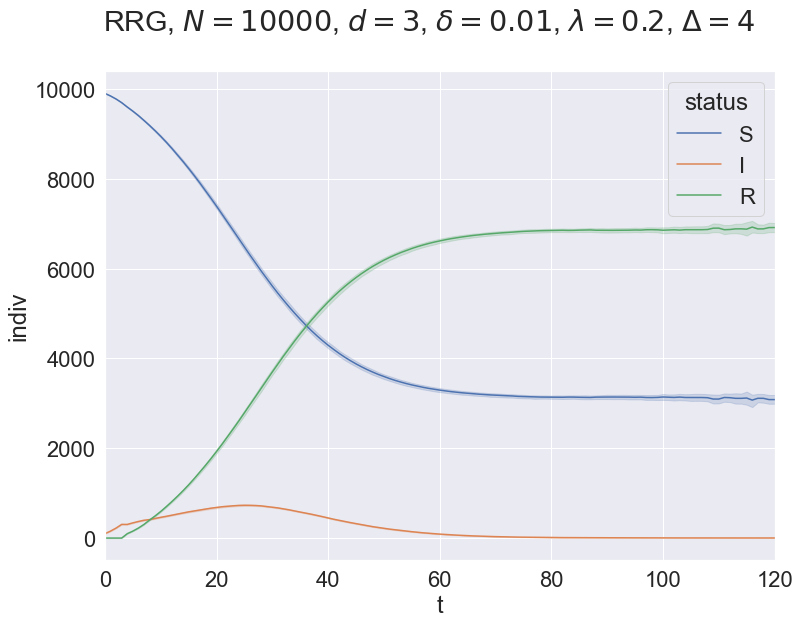

In [257]:
fig,ax = plt.subplots(1,1, figsize=(12,9))
sns.set_theme(font_scale=2)
plt.suptitle(f"RRG, $N=10000$, $d=3$, $\\delta=0.01$, $\\lambda=0.2$, $\\Delta=4$")
sns.lineplot(data=data, x="t", y="indiv", hue="status", ci=95, ax=ax)
ax.set_xlim(0,120)
#fig.savefig(f"simDetSIR_Ave.pdf")

### Run BP

In [14]:
from bpepi.sim_on_cluster import generate_contacts
T=13
lamb_=lam
contacts = generate_contacts(G, T, lamb_)

In [15]:
from bpepi.fg import FactorGraph
fg_ = FactorGraph(N_graph, T, contacts, [], delta, mask = [1]*Delta)

In [16]:
fg_.update(tol=1e-10)

(15, 7.216449660063518e-16)

In [17]:
Lambda0 = fg_.Lambda0
Lambda1 = fg_.Lambda1

In [18]:
Lambda1.values[0]

array([[1.   , 1.   , 0.2  , 0.04 , 0.008, 0.008, 0.008, 0.008, 0.008,
        0.008, 0.008, 0.008, 0.008, 0.008, 0.008],
       [1.   , 1.   , 1.   , 0.2  , 0.04 , 0.008, 0.008, 0.008, 0.008,
        0.008, 0.008, 0.008, 0.008, 0.008, 0.008],
       [1.   , 1.   , 1.   , 1.   , 0.2  , 0.04 , 0.008, 0.008, 0.008,
        0.008, 0.008, 0.008, 0.008, 0.008, 0.008],
       [1.   , 1.   , 1.   , 1.   , 1.   , 0.2  , 0.04 , 0.008, 0.008,
        0.008, 0.008, 0.008, 0.008, 0.008, 0.008],
       [1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.2  , 0.04 , 0.008,
        0.008, 0.008, 0.008, 0.008, 0.008, 0.008],
       [1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.2  , 0.04 ,
        0.008, 0.008, 0.008, 0.008, 0.008, 0.008],
       [1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.2  ,
        0.04 , 0.008, 0.008, 0.008, 0.008, 0.008],
       [1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
        0.2  , 0.04 , 0.008, 0.008, 0.008, 0.008],
       [1.   , 1.   , 1.

In [19]:
Lambda0.values[0]

array([[1.   , 0.2  , 0.04 , 0.008, 0.008, 0.008, 0.008, 0.008, 0.008,
        0.008, 0.008, 0.008, 0.008, 0.008, 0.008],
       [1.   , 1.   , 0.2  , 0.04 , 0.008, 0.008, 0.008, 0.008, 0.008,
        0.008, 0.008, 0.008, 0.008, 0.008, 0.008],
       [1.   , 1.   , 1.   , 0.2  , 0.04 , 0.008, 0.008, 0.008, 0.008,
        0.008, 0.008, 0.008, 0.008, 0.008, 0.008],
       [1.   , 1.   , 1.   , 1.   , 0.2  , 0.04 , 0.008, 0.008, 0.008,
        0.008, 0.008, 0.008, 0.008, 0.008, 0.008],
       [1.   , 1.   , 1.   , 1.   , 1.   , 0.2  , 0.04 , 0.008, 0.008,
        0.008, 0.008, 0.008, 0.008, 0.008, 0.008],
       [1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.2  , 0.04 , 0.008,
        0.008, 0.008, 0.008, 0.008, 0.008, 0.008],
       [1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.2  , 0.04 ,
        0.008, 0.008, 0.008, 0.008, 0.008, 0.008],
       [1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.2  ,
        0.04 , 0.008, 0.008, 0.008, 0.008, 0.008],
       [1.   , 1.   , 1.

In [39]:
Mask0 = np.array([ np.asarray(([1]*(tj+1) + mask + [0]*(Tp2-len(mask)-tj-1) )[:Tp2]) for tj in range(Tp2) ])
Mask1 = np.array([ np.asarray(([1]*(tj+2) + mask + [0]*(Tp2-len(mask)-tj-2) )[:Tp2]) for tj in range(Tp2) ])

In [42]:
Mask1

array([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [13]:
B = fg_.marginals()

In [14]:
B[0]

array([0.005     , 0.00298202, 0.00356401, 0.00425618, 0.00507788,
       0.00605124, 0.00720125, 0.00855569, 0.01014485, 0.94716688])